In [1]:
from lib.util import load_file

In [2]:
def fix_json_file(file_path):
    """Fix the JSON file by adding brackets and commas."""

    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
        
        # Remove any existing comments
        lines = [line for line in lines if not line.strip().startswith('#')]
        
        # Add commas between lines and wrap with brackets
        fixed_json = '[\n' + ',\n'.join(line.strip() for line in lines) + '\n]'
        
        with open(file_path, 'w') as file:
            file.write(fixed_json)
        
        print(f"Fixed JSON file saved to {file_path}")
    
    except Exception as e:
        print(f"An error occurred: {e}")

In [3]:
# fix_json_file('pheme-raw/annotations/en-scheme-annotations.json')

def create_and_classify_annotations():
    """Create a dictionary for quick lookups and classify tweets."""
    
    annotations = load_file("pheme-raw/annotations/en-scheme-annotations.json")
    print(f"Number of annotations: {len(annotations)}")
    
    def classify(item):
        if item.get("support"):
            return "source"
        elif item.get("responsetype-vs-source") and item.get("responsetype-vs-previous"):
            return "deep reply"
        elif item.get("responsetype-vs-source"):
            return "direct reply"
        return "unknown"
    
    # Key is tweet ID: int
    annotations_dict = {
        int(item["tweetid"]): {
            "class": classify(item),
            "support": item.get("support"),
            "responsetype-vs-source": item.get("responsetype-vs-source"),
            "responsetype-vs-previous": item.get("responsetype-vs-previous")
        }
        for item in annotations
    }
    
    return annotations_dict

annotations_dict = create_and_classify_annotations()

Number of annotations: 4560


In [4]:
import json
import pandas as pd

class Tweets:
    def __init__(self, event_name, output_dir="data/tweets"):
        self.event = event_name
        self.data = []
        self.output_dir = output_dir
    
    def append(self, tweet, thread_id):
        def safe_int(value, default=0):
            return int(value) if value is not None else default
    
        tweet_id = tweet['id']
        tweet_data = {
            "tweet_id": tweet_id,
            "thread_id": int(thread_id),
            "class": annotations_dict.get(tweet_id, {}).get('class', 'retweet'),
            "support": annotations_dict.get(tweet_id, {}).get('support'),
            "responsetype-vs-source": annotations_dict.get(tweet_id, {}).get('responsetype-vs-source'),
            "responsetype-vs-previous": annotations_dict.get(tweet_id, {}).get('responsetype-vs-previous'),
            "favorite_count": tweet['favorite_count'],
            "retweeted": tweet['retweeted'],
            "retweet_count": tweet['retweet_count'],
            "in_reply_to_user_id": safe_int(tweet['in_reply_to_user_id']),
            "favorited": tweet['favorited'],
            "user_id": tweet['user']['id'],
            "created_at": tweet['created_at'],
            "place": tweet['place'],
        }
        
        self.data.append(tweet_data)

    def export(self):
        output_file = f"{self.output_dir}/{self.event}.csv"
        df = pd.DataFrame(data=self.data)
        df.to_csv(output_file, index=False)
        return output_file
        
    def print_data_info(self):
        for tweet_data in self.data:
            print(json.dumps(tweet_data, indent=4))
        
        print(f"Total tweets: {len(self.data)}")

In [5]:
import time
import os

def pheme_to_csv(event, Parser=Tweets, output="data/tweets"):
    start = time.time()
    parser = Parser(event, output_dir=output)
    path = "pheme-raw/threads/en"
    thread_number = 0

    for thread in os.listdir(f"{path}/{event}"):
        thread_number += 1

        for source_tweet in os.listdir(f"{path}/{event}/{thread}/source-tweets"):   # json 
            src_twt = load_file(f"{path}/{event}/{thread}/source-tweets/{source_tweet}")
            parser.append(src_twt, thread)

        for reaction in os.listdir(f"{path}/{event}/{thread}/reactions"):
            tweet = load_file(f"{path}/{event}/{thread}/reactions/{reaction}")
            parser.append(tweet, thread)

        retweets_file = f"{path}/{event}/{thread}/retweets.json"
        if os.path.exists(retweets_file):
            # fix_json_file(retweets_file)
            retweets = load_file(retweets_file)
            for retweet in retweets:
                parser.append(retweet, thread)

    output_file = parser.export()
    print(f"{output_file} was generated in {(time.time() - start) / 60} minutes")

    parser.print_data_info()
    
    return None

pheme_to_csv("ebola-essien")

data/tweets/ebola-essien.csv was generated in 0.0033871730168660483 minutes
{
    "tweet_id": 521346721226711040,
    "thread_id": 521346721226711040,
    "class": "source",
    "support": "supporting",
    "responsetype-vs-source": null,
    "responsetype-vs-previous": null,
    "favorite_count": 85,
    "retweeted": false,
    "retweet_count": 575,
    "in_reply_to_user_id": 0,
    "favorited": false,
    "user_id": 579635019,
    "created_at": "Sun Oct 12 17:08:39 +0000 2014",
    "place": null
}
{
    "tweet_id": 521349366037356544,
    "thread_id": 521346721226711040,
    "class": "direct reply",
    "support": null,
    "responsetype-vs-source": "appeal-for-more-information",
    "responsetype-vs-previous": null,
    "favorite_count": 5,
    "retweeted": false,
    "retweet_count": 1,
    "in_reply_to_user_id": 579635019,
    "favorited": false,
    "user_id": 463260500,
    "created_at": "Sun Oct 12 17:19:09 +0000 2014",
    "place": null
}
{
    "tweet_id": 521349434719076352,


In [6]:
from lib.util import fetch_tweets

event = "ebola-essien"
tweets_df = fetch_tweets(event)

In [7]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tweet_id                  216 non-null    int64 
 1   thread_id                 216 non-null    int64 
 2   class                     216 non-null    object
 3   support                   2 non-null      object
 4   responsetype-vs-source    32 non-null     object
 5   responsetype-vs-previous  10 non-null     object
 6   favorite_count            216 non-null    int64 
 7   retweeted                 216 non-null    bool  
 8   retweet_count             216 non-null    int64 
 9   in_reply_to_user_id       216 non-null    object
 10  favorited                 216 non-null    bool  
 11  user_id                   216 non-null    int64 
 12  created_at                216 non-null    object
 13  place                     2 non-null      object
dtypes: bool(2), int64(5), obje

In [8]:
tweets_df.head()

,tweet_id,thread_id,class,support,responsetype-vs-source,responsetype-vs-previous,favorite_count,retweeted,retweet_count,in_reply_to_user_id,favorited,user_id,created_at,place
0,521346721226711040,521346721226711040,source,supporting,NaN,NaN,85,False,575,0,False,579635019,Sun Oct 12 17:08:39 +0000 2014,NaN
1,521349366037356544,521346721226711040,direct reply,NaN,appeal-for-more-information,NaN,5,False,1,579635019,False,463260500,Sun Oct 12 17:19:09 +0000 2014,NaN
2,521349434719076352,521346721226711040,direct reply,NaN,comment,NaN,1,False,1,579635019,False,430026970,Sun Oct 12 17:19:26 +0000 2014,NaN
3,521350130851921921,521346721226711040,direct reply,NaN,comment,NaN,0,False,0,579635019,False,379856833,Sun Oct 12 17:22:12 +0000 2014,"{'full_name': 'Brasília, Distrito Federal', 'u..."
4,521350466647891968,521346721226711040,direct reply,NaN,comment,NaN,1,False,0,579635019,False,458672503,Sun Oct 12 17:23:32 +0000 2014,NaN


Node with the most edges: 0, Number of edges: 182


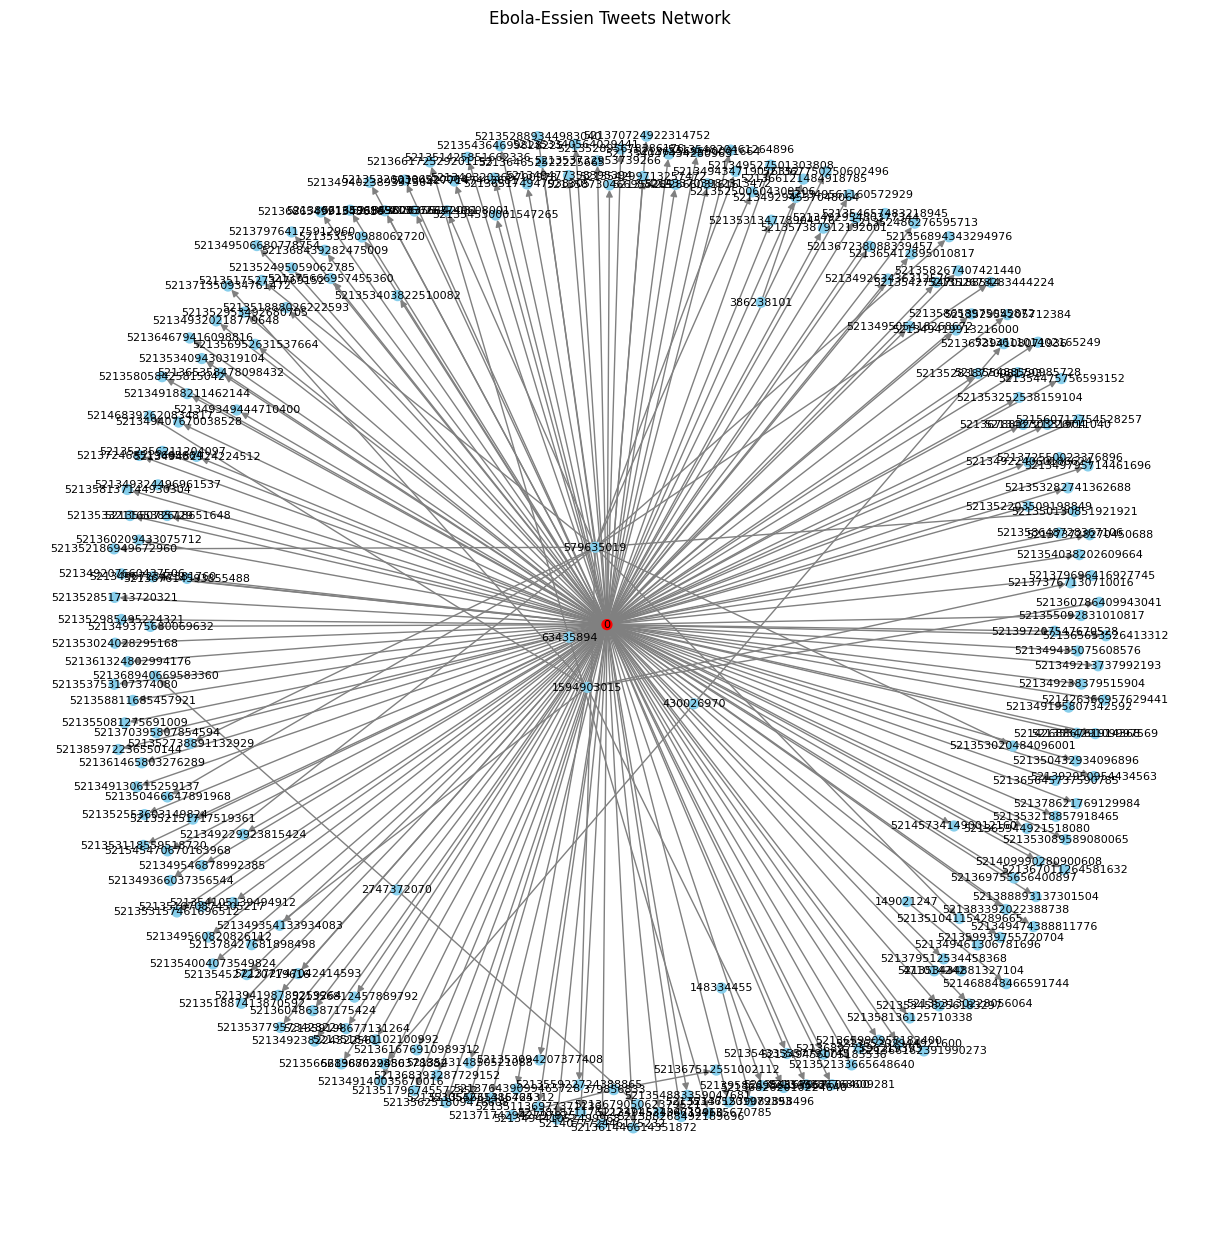

In [28]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for _, tweet in tweets_df.iterrows():
    tweet_id = tweet['tweet_id']
    user_id = tweet['user_id']
    in_reply_to_user_id = tweet['in_reply_to_user_id']
    
    # Add the tweet as a node with user_id as an attribute
    G.add_node(tweet_id, user_id=user_id)
    
    # Add an edge directed from in_reply_to_user_id to tweet_id
    if in_reply_to_user_id:
        G.add_edge(in_reply_to_user_id, tweet_id)
    
# Remove node 0!!!
if G.has_node(0):
    print("Removing node 0")
    G.remove_node(0)

# Find the node with the most edges
node_with_most_edges = max(G.degree, key=lambda x: x[1])
print(f"Node with the most edges: {node_with_most_edges[0]}, Number of edges: {node_with_most_edges[1]}")

# Create a color map for the nodes
node_colors = ['red' if node == node_with_most_edges[0] else 'skyblue' for node in G.nodes()]

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.1)
nx.draw(G, pos, with_labels=True, node_size=50, node_color=node_colors, font_size=8, font_color="black", edge_color="gray")
plt.title("Ebola-Essien Tweets Network")
plt.show()